# Data exploration

This notebook is dedicated to the analysis of the Enron email dataset. The goal is to go through the data, extract features and train a classification algorithm on it.

Here the classification task is to predict professional and personal emails.

Also, since some algorithms are semi-supervised, the full data-set (from https://www.kaggle.com/wcukierski/enron-email-dataset) is also used.

## Environnement setup

In [1]:
import os
import re
import csv
import pandas as pd
import email
import matplotlib.pyplot as plt
%matplotlib inline

from utils.tokenizer import *

In [2]:
sup_path = './data/sup/'
unsup_path = './data/unsup/'
business_path = sup_path + 'business/'
personal_path = sup_path + 'personal/'
encoding = 'utf-8'

if not os.path.isdir(sup_path):
    os.mkdir(sup_path)
if not os.path.isdir(unsup_pat):
    os.mkdir(unsup_path)
if not os.path.isdir(sup_path+'processed_data'):
    os.mkdir(sup_path+'processed_data')
if not os.path.isdir(unsup_path+'processed_data'):
    os.mkdir(unsup_path+'processed_data')

# Create a emails.csv file for faster work
if not os.path.isfile(sup_path+'emails.csv'):
    with open(sup_path+'emails.csv', 'w', encoding=encoding, newline= '') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=['file', 'message', 'label'], delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
        writer.writeheader()
        # Open professionl emails and label them 0
        label=0
        for filename in os.listdir(business_path):
            with open(business_path+filename, 'r', encoding=encoding) as f:
                writer.writerow({'file': filename, 'message': f.read(), 'label':label})
                
        # Open personal emails and label them 1
        label=1
        for filename in os.listdir(personal_path):
            try:
                with open(personal_path+filename, 'r', encoding=encoding) as f:
                    writer.writerow({'file': filename, 'message': f.read(), 'label':label})
            # Encoding exception if default encoding doesn't work
            except:
                with open(personal_path+filename, 'r', encoding='ansi') as f:
                    writer.writerow({'file': filename, 'message': f.read(), 'label':label})

## Data opening

In [3]:
# Read the supervised data into a DataFrame
emails = pd.read_csv(sup_path+'emails.csv')
nb_sup_emails = emails.shape[0]
print('Total of %d emails in the supervised dataset'% (nb_sup_emails))
emails.head()

Total of 6385 emails in the supervised dataset


,file,message,label
0,maildir_allen-p_inbox_23,"Date: Tue, 23 Oct 2001 15:14:37 -0700 (PDT)\nF...",0
1,maildir_allen-p_inbox_84,"Date: Mon, 26 Nov 2001 08:31:11 -0800 (PST)\nF...",0
2,maildir_allen-p_inbox_85,"Date: Mon, 26 Nov 2001 15:33:45 -0800 (PST)\nF...",0
3,maildir_allen-p_notes_inbox_32,"Date: Tue, 12 Dec 2000 23:04:00 -0800 (PST)\nF...",0
4,maildir_allen-p_notes_inbox_39,"Date: Thu, 7 Dec 2000 01:55:00 -0800 (PST)\nFr...",0


In [4]:
# Read the supervised data into a DataFrame and label it 2
unsup_emails = pd.read_csv(unsup_path+'emails.csv')
print('Total of %d emails in the unsupervised dataset'% (unsup_emails.shape[0]))
unsup_emails['label'] = 2
unsup_emails.head()

emails = pd.concat([emails, unsup_emails])
del unsup_emails

Total of 517401 emails in the unsupervised dataset


In [5]:
emails.drop_duplicates()
print('Total of %d emails in the Total dataset'% (emails.shape[0]))

Total of 523786 emails in the Total dataset


## Email Parsing

The whole content of the emails are in the 'message' column, it will then be necessary to parse it to extract information.

Important to note that the tag MARKUP and its content have been deleted, because they provide the label which would be used by the classifier and biaised the data.

In [6]:
# Regex to remove html tag and content
cleaner = re.compile('<.*?>.*?<.*?>')

def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(part.get_payload())
    text = ''.join(parts)
    # Remove the MARKUP tag and content because they give the label
    return re.sub(cleaner, '', text)

def get_domains(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        domains = []
        for addr in addrs:
            try:
                # seperate users and domain
                domain = addr.split('@')[1]
                domains.append(domain.strip())
            except:
                print(addr)
        addrs = domains
    else:
        addrs = frozenset()
    return frozenset(map(lambda x: x.strip(), addrs))

def get_users(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        users = []
        for addr in addrs:
            try:
                # seperate users and domain to create categorical data later-on (ex: 0 for non enron mail, 1 else)
                user = addr.split('@')[0]
                users.append(user.strip())
            except:
                print(addr)
        addrs = users
    else:
        addrs = frozenset()
    return frozenset(map(lambda x: x.strip(), addrs))

In [7]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523786 entries, 0 to 517400
Data columns (total 3 columns):
file       523786 non-null object
message    523786 non-null object
label      523786 non-null int64
dtypes: int64(1), object(2)
memory usage: 16.0+ MB


In [8]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails[key] = [doc[key] for doc in messages]
    
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

# Parse date to have categorical data
dates = pd.to_datetime(emails['Date'], infer_datetime_format=True)
emails['Year'] = dates.dt.year
emails['DayOfWeek'] = dates.dt.dayofweek
emails['Hour'] = dates.dt.hour

# Split multiple email addresses
emails['FromDomain'] = emails['From'].map(get_domains)
emails['FromUser'] = emails['From'].map(get_users)
emails['ToDomain'] = emails['To'].map(get_domains)
emails['ToUser'] = emails['To'].map(get_users)
emails.drop(['From', 'To'], axis=1, inplace=True)

del messages
del dates

emails.loc[:nb_sup_emails, 'user'] = emails.loc[:nb_sup_emails, 'file'].map(lambda x:x.split('-')[0])
emails.loc[nb_sup_emails:, 'user'] = emails.loc[nb_sup_emails:, 'file'].map(lambda x:x.split('/')[0])

emails.head()

pep <performance.>
e-mail <mari.>
 e-mail <gretchen.>
 nepco <patrick.>
 nepco <patrick.>
 nepco <patrick.>
 e-mail <roger.>
 e-mail <roger.>
w/assts <govt.>
w/assts <govt.>
 e-mail <sy.>
 
	e-mail <anthony.>
 e-mail <brian.>
f62489 <g>
 e-mail <gretchen.>
 e-mail <roger.>
w/assts <govt.>
 e-mail <sy.>
 
	e-mail <anthony.>
 e-mail <brian.>
w/assts <govt.>
 contract <jeff>
cats <breaktkhrough.>
 risk <breakthrough.>
 leaders <breaktkhrough.>
dogs <breakthrough.>
 cats <breaktkhrough.>
 risk <breakthrough.>
 
	leaders <breaktkhrough.>
dogs <breakthrough.>
 cats <breaktkhrough.>
 risk <breakthrough.>
 
	leaders <breaktkhrough.>
cats <breaktkhrough.>
 risk <breakthrough.>
 leaders <breaktkhrough.>
dogs <breakthrough.>
 cats <breaktkhrough.>
 risk <breakthrough.>
 
	leaders <breaktkhrough.>
cats <breaktkhrough.>
 risk <breakthrough.>
 leaders <breaktkhrough.>
w/assts <govt.>
 a <international.>
w/assts <govt.>
w/assts <govt.>
w/assts <govt.>
 a <international.>
w/assts <govt.>
w/assts <govt

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user
0,maildir_allen-p_inbox_23,0,"Tue, 23 Oct 2001 15:14:37 -0700 (PDT)",Properties for sale,PALLEN (Non-Privileged).pst,There are three other deals that I will fax to...,2001.0,1.0,22.0,(austintx.com),(jsmith),(enron.com),(k..allen),maildir_allen
1,maildir_allen-p_inbox_84,0,"Mon, 26 Nov 2001 08:31:11 -0800 (PST)",Answer,PALLEN (Non-Privileged).pst,For purposes of an accelerated distribution fr...,2001.0,0.0,16.0,(enron.com),(david.oxley),(enron.com),(k..allen),maildir_allen
2,maildir_allen-p_inbox_85,0,"Mon, 26 Nov 2001 15:33:45 -0800 (PST)",Wednesday Meeting,PALLEN (Non-Privileged).pst,"Phillip,\n\nI will get a room for our Wednesda...",2001.0,0.0,23.0,(accenture.com),(mery.l.brown),(enron.com),(pallen),maildir_allen
3,maildir_allen-p_notes_inbox_32,0,"Tue, 12 Dec 2000 23:04:00 -0800 (PST)",New Notice from Transwestern Pipeline Co.,pallen.nsf,Transwestern Pipeline Co. posted new notice(s)...,2000.0,2.0,7.0,(enron.com),(critical.notice),(enron.com),"(phillip.k.allen, jane.m.tholt, ywang, patti.s...",maildir_allen
4,maildir_allen-p_notes_inbox_39,0,"Thu, 7 Dec 2000 01:55:00 -0800 (PST)",System Development,pallen.nsf,Can you please review the following systems pr...,2000.0,3.0,9.0,(enron.com),(tiffany.miller),(enron.com),"(phillip.allen, barry.tycholiz)",maildir_allen


In [9]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523786 entries, 0 to 517400
Data columns (total 14 columns):
file          523786 non-null object
label         523786 non-null int64
Date          523763 non-null object
Subject       523763 non-null object
X-FileName    523734 non-null object
content       523786 non-null object
Year          523763 non-null float64
DayOfWeek     523763 non-null float64
Hour          523763 non-null float64
FromDomain    523786 non-null object
FromUser      523786 non-null object
ToDomain      523786 non-null object
ToUser        523786 non-null object
user          523786 non-null object
dtypes: float64(3), int64(1), object(10)
memory usage: 79.9+ MB


In [10]:
# Find number of unique values in each columns
for col in emails.columns:
    if col != 'From' and col != 'To':
        print(col, emails[col].nunique())

file 523786
label 3
Date 224130
Subject 159290
X-FileName 429
content 255220
Year 16
DayOfWeek 7
Hour 24
FromDomain 5294
FromUser 18995
ToDomain 8033
ToUser 53700
user 399


## Data cleansing

### Checking fo outliers in Subject.

In [11]:
emails[[Subject == None for i, Subject in enumerate(emails['Subject'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user
5074,maildir_baughman-d_personal_letters_42,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_baughman
5342,maildir_farmer-d_personal_129,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5343,maildir_farmer-d_personal_16,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5370,maildir_farmer-d_personal_295,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_farmer
5426,maildir_germany-c_personal_44,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_germany
5545,maildir_hyatt-k_personal_100,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_hyatt
5598,maildir_kaminski-v_personal_131,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5605,maildir_kaminski-v_personal_274,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5616,maildir_kaminski-v_personal_323,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_kaminski
5617,maildir_kaminski-v_personal_337,1,None,None,None,,NaN,NaN,NaN,(),(),(),(),maildir_kaminski


Most of the columns are empty for these lines, so it's preferable to drop them

In [12]:
emails.drop([i for i, Subject in enumerate(emails['Subject']) if Subject == None], inplace=True)

### Checking for extensivly long content.

Some content are too long in the unsupervised dataset, and considered outliers. The maximum length threshold is based on the maximum length of the supervised dataset multiplied by 1,2

In [13]:
max_len = 100000

emails[[len(content) > max_len for content in emails['content']]]['content'].head()

6201     Enron Discusses Credit Line of $1 Billion to $...
18224    Wow, gimme some of that makeup!  Its amazing w...
29029    =09Please advise today if there were books mis...
29030    =20\n\n -----Original Message-----\nFrom: =09W...
29031    Over the past few weeks, we've put together so...
Name: content, dtype: object

In [14]:
emails.drop([i for i, content in enumerate(emails['content']) if len(content) > max_len], inplace=True)

In [15]:
emails[[file == None for i, file in enumerate(emails['X-FileName'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user
18162,baughman-d/calendar/19.,2,"Wed, 12 Sep 2001 06:20:48 -0700 (PDT)",Fundamental Overview Presentation,None,"Friday, September 21st\n1 -\n 3pm\nroom 32c2\n...",2001.0,2.0,13.0,(enron.com),(don.baughman),(),(),baughman-d
18178,baughman-d/calendar/4.,2,"Thu, 13 Dec 2001 06:38:40 -0800 (PST)",Midwest/Southeast Desk Meeting w/Fletch Sturm,None,"Wednesday, September\n 19th \n3 - 3:30pm\nRo...",2001.0,3.0,14.0,(enron.com),(don.baughman),(),(),baughman-d
18179,baughman-d/calendar/5.,2,"Wed, 14 Nov 2001 13:31:53 -0800 (PST)",Congestion in the transmission system for t...,None,"Interconnect""\nMime-Version: 1.0\nContent-Type...",2001.0,2.0,21.0,(enron.com),(don.baughman),(),(),baughman-d
18414,baughman-d/deleted_items/303.,2,"Thu, 13 Dec 2001 06:39:18 -0800 (PST)",Call Laddie for house party:,None,1. Mom &dad\n2. Troy & Andrea\n3. Reagan\n & M...,2001.0,3.0,14.0,(enron.com),(don.baughman),(),(),baughman-d
20506,baughman-d/tasks/4.,2,"Thu, 13 Dec 2001 06:39:18 -0800 (PST)",Call Laddie for house party:,None,1. Mom &dad\n2. Troy & Andrea\n3. Reagan\n & M...,2001.0,3.0,14.0,(enron.com),(don.baughman),(),(),baughman-d
43636,campbell-l/inbox/1040.,2,"Tue, 20 Nov 2001 15:17:00 -0800 (PST)",Are you taking full advantage of Streamer,None,?\nMime-Version: 1.0\nContent-Type: text/plain...,2001.0,1.0,23.0,(datek2.m0.net),(announcements),(enron.com),(lcampbel),campbell-l
122535,geaccone-t/inbox/537.,2,"Tue, 20 Nov 2001 15:38:39 -0800 (PST)",Are you taking full advantage of Streamer,None,?\nMime-Version: 1.0\nContent-Type: text/plain...,2001.0,1.0,23.0,(datek2.m0.net),(announcements),(enron.com),(tgeacco),geaccone-t
153761,haedicke-m/calendar/37.,2,"Mon, 11 Jun 2001 20:08:14 -0700 (PDT)","Greg Piper, Travis McCullough - re: Legal Issues",None,Mark's Office -\n EB3325\nMime-Version: 1.0\nC...,2001.0,1.0,3.0,(enron.com),(outlook-migration-team),(),(),haedicke-m
165738,hendrickson-s/deleted_items/67.,2,"Fri, 1 Jun 2001 15:19:00 -0700 (PDT)",Step Right Into Summer with Improvements,None,!\nMime-Version: 1.0\nContent-Type: text/plain...,2001.0,4.0,22.0,(s2u2.com),(improvements.100412385),(ect.enron.com),(shendri),hendrickson-s
211334,kaminski-v/calendar/3.,2,"Mon, 5 Nov 2001 11:29:01 -0800 (PST)",Rice University Spring 2002 - Electives Previe...,None,"Room\n 124, 656:\tEnergy Derivatives\tKaminski...",2001.0,0.0,19.0,(enron.com),(j.kaminski),(),(),kaminski-v


In [16]:
emails[[user == None for i, user in enumerate(emails['user'])]]

,file,label,Date,Subject,X-FileName,content,Year,DayOfWeek,Hour,FromDomain,FromUser,ToDomain,ToUser,user


# Tokenize

Now it's time to tokenize the content and Subject. The tokenizer used is Spacy. No Part of Speech neither Named entity were used, but will be considered if the result of the classifiers are not sufficient.

In [17]:
from utils.tokenizer import corpus, to_BoW, get_vocab, index_corpus

In [18]:
subjects_corpus = corpus(emails['Subject'], stop_words = False)
emails['Subjects_indexed'] = subjects_corpus.indexed

100%|████████████████████████████████████████████████████████████████████████| 523393/523393 [03:07<00:00, 2793.57it/s]


In [19]:
contents_corpus = corpus(emails['content'], stop_words = False)
emails['content_indexed'] = contents_corpus.indexed

100%|████████████████████████████████████████████████████████████████████████| 523393/523393 [3:10:45<00:00, 62.72it/s]


## Emails content lengths

If the contents are going to be used for the classifier, the length play a big part in the decision of the algorithm.
Indeed, Recurrent Neural Network, for example, start to be less interesting after ~100 tokens, plus, the training time can get pretty long.

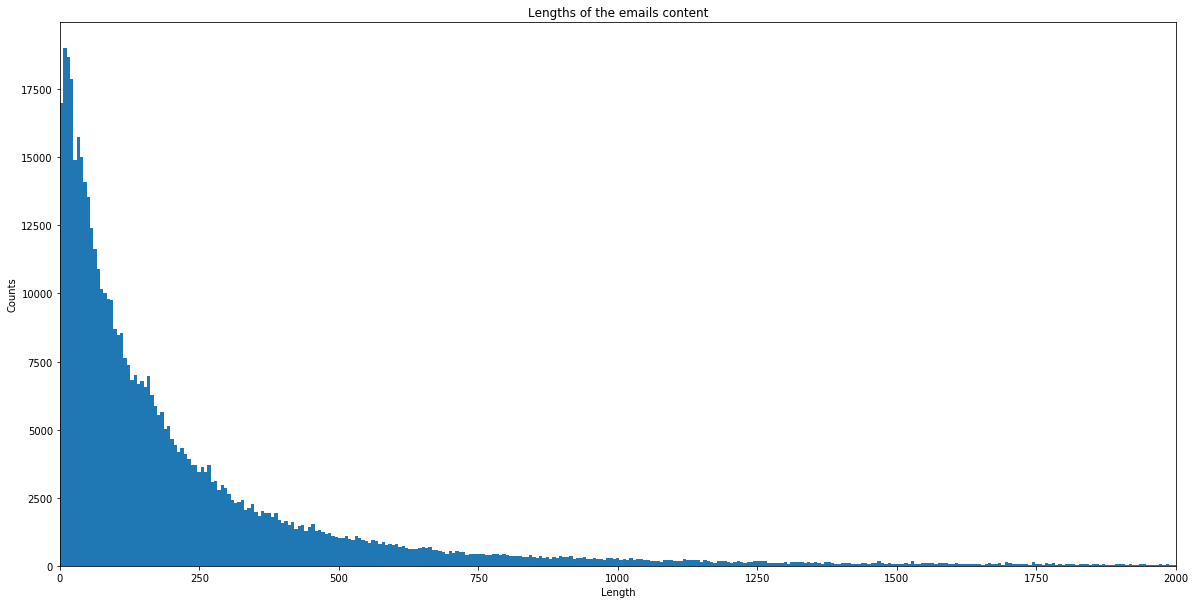

In [21]:
import matplotlib.pyplot as plt

lengths = [len(content) for content in emails['content_indexed']]

plt.figure(figsize=(20,10))
plt.hist(lengths, bins='auto') 
plt.xlim((0,2000))
plt.title('Lengths of the emails content')
plt.ylabel('Counts')
plt.xlabel('Length')
plt.show()

## Convert From, To, Subject and content to Bag of Words

In [22]:
users = get_vocab(emails['FromUser'].tolist() + emails['ToUser'].tolist())
domains = get_vocab(emails['FromDomain'].tolist() + emails['ToDomain'].tolist())

In [23]:
processed_data = dict()

processed_data['FromUser'] = to_BoW(index_corpus(emails['FromUser'].tolist(), users), users)
processed_data['ToUser'] = to_BoW(index_corpus(emails['ToUser'].tolist(), users), users)
processed_data['FromDomain'] = to_BoW(index_corpus(emails['FromDomain'].tolist(), domains), domains)
processed_data['ToDomain'] = to_BoW(index_corpus(emails['ToDomain'].tolist(), domains), domains)
processed_data['Subject'] = subjects_corpus.BoW
processed_data['content'] = contents_corpus.BoW

## Convert Year, Day and Hour to onehot

In [24]:
from scipy.sparse import csr_matrix

def to_onehot(listOfNums):
    listOfNums = listOfNums.astype(int)
    min_value = min(listOfNums)   
    data = [1] * len(listOfNums)
    row = np.arange(len(listOfNums))
    col = listOfNums - min_value
    shape = (len(listOfNums), max(listOfNums) - min_value + 1)
    out = csr_matrix((data, (row, col)), shape=shape)
    return out

In [25]:
processed_data['Year'] = to_onehot(emails['Year'].values)
processed_data['Day'] = to_onehot(emails['DayOfWeek'].values)
processed_data['Hour'] = to_onehot(emails['Hour'].values)

## Save the vocabularies and Bag of Words

In [26]:
from scipy.sparse import save_npz

for key in processed_data.keys():
    save_npz(sup_path+'processed_data/'+key+'.npz', processed_data[key])

vocab = subjects_corpus.vocab[:]
for i, idf in enumerate(subjects_corpus.idf):
    vocab[i] += (idf, )
with open('./data/Subjects_vocab.csv', 'w', newline='', encoding=encoding) as f:
    csv_writer = csv.writer(f, delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    csv_writer.writerow(['word', 'count', 'idf'])
    csv_writer.writerows(vocab)
    
vocab = contents_corpus.vocab[:]
for i, idf in enumerate(contents_corpus.idf):
    vocab[i] += (idf, )
with open('./data/contents_vocab.csv', 'w', newline='', encoding=encoding) as f:
    csv_writer = csv.writer(f, delimiter =',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
    csv_writer.writerow(['word', 'count', 'idf'])
    csv_writer.writerows(vocab)

In [ ]:
emails.to_pickle('./data/emails.pkl')